# Approximating double n-capture

We want to approximate the sequence $A(n,\gamma)X(n,\gamma)B$ as $A(nn,\gamma)B$ by combining the two successive neutron captures into a single rate, assuming equilibrium of nucleus $X$.

This type of approximation is commonly done in the "aprox" family of networks, for example, approximating the sequence:
${}^{52}\mathrm{Fe}(n,\gamma){}^{53}\mathrm{Fe}(n,\gamma){}^{54}\mathrm{Fe}$.

In [1]:
import pynucastro as pyna

In [2]:
rl = pyna.ReacLibLibrary()

## Unapproximated version

We'll create a simple network of iron isotopes linked by neutron capture.

In [3]:
lib = rl.linking_nuclei(["fe52", "fe53", "fe54", "n"])

In [4]:
rc = pyna.PythonNetwork(libraries=[lib])
rc.write_network("ncapture.py")

In [5]:
import ncapture

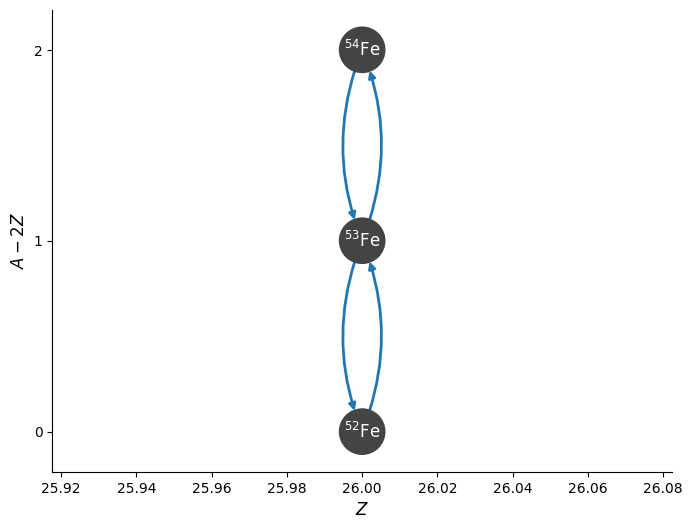

In [6]:
fig = rc.plot(rotated=True, curved_edges=True)

Now we'll integrate it, starting with a mix of ${}^{52}\mathrm{Fe}$ and $n$.

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [8]:
rho = 1.e9
T = 3.e9

X0 = np.zeros(ncapture.nnuc)
X0[ncapture.jn] = 0.5
X0[ncapture.jfe52] = 0.5
Y0 = X0 / ncapture.A

In [9]:
tmax = 1.e-5
sol = solve_ivp(ncapture.rhs, [0, tmax], Y0, method="BDF", jac=ncapture.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-8)

Text(0, 0.5, 'X')

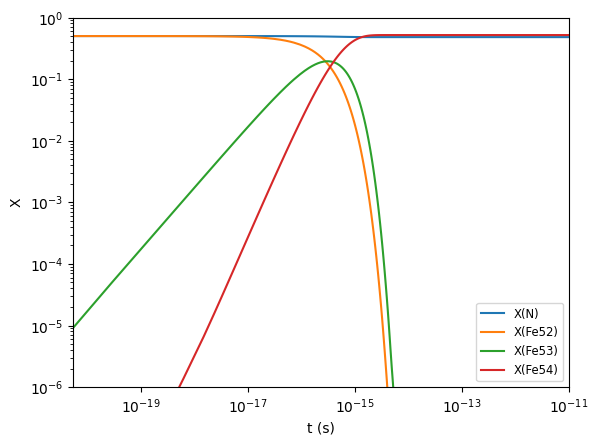

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(ncapture.nnuc):
    ax.loglog(sol.t, sol.y[i,:] * ncapture.A[i], label=f"X({ncapture.names[i].capitalize()})")

ax.set_xlim(right=1.e-11)
ax.set_ylim(1.e-6, 1)

ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

We see that the long term evolution is that all the iron winds up as ${}^{54}\mathrm{Fe}$.

## Approximating the double n capture

We can use the helper function `create_double_neutron_capture()` to create a pair (forward and reverse) of `ApproximateRates` that approximate out the intermedia nucleus:

In [11]:
rf, rr = pyna.rates.create_double_neutron_capture(rl, pyna.Nucleus("fe52"), pyna.Nucleus("fe54"))

In [12]:
rf

Fe52 + 2 n ⟶ Fe54 + 𝛾

We can see what rates this carries internally:

In [13]:
rf.hidden_rates

[Fe52 + n ⟶ Fe53 + 𝛾, Fe53 + n ⟶ Fe54 + 𝛾, Fe54 ⟶ n + Fe53, Fe53 ⟶ n + Fe52]

```{tip}
Alternately, we could use the `make_nn_g_approx()` method on the `PythonNetwork` once we create it.
```

Now we'll build a new network with just these approximate rates:

In [14]:
rc2 = pyna.PythonNetwork(rates=[rf, rr])
rc2.write_network("ncapture_approx.py")

In [15]:
import ncapture_approx

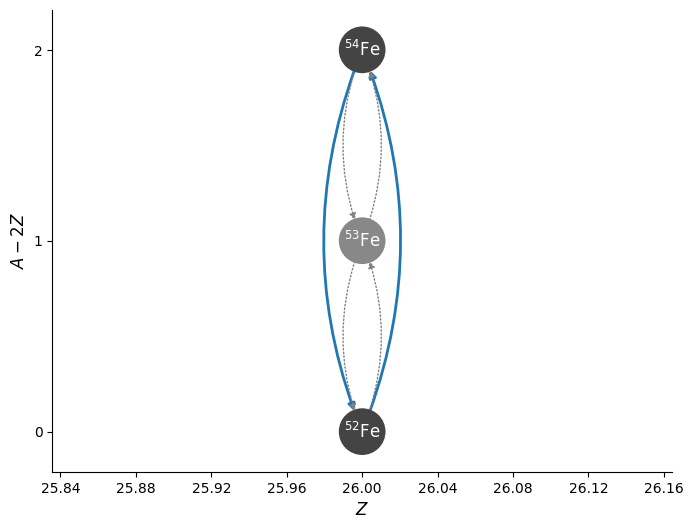

In [16]:
fig = rc2.plot(rotated=True, curved_edges=True)

In [17]:
rho = 1.e9
T = 3.e9

X0 = np.zeros(ncapture_approx.nnuc)
X0[ncapture_approx.jn] = 0.5
X0[ncapture_approx.jfe52] = 0.5
Y0 = X0 / ncapture_approx.A

In [18]:
tmax = 1.e-5
approx_sol = solve_ivp(ncapture_approx.rhs, [0, tmax], Y0, method="BDF", jac=ncapture_approx.jacobian,
                       dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-8)

Text(0, 0.5, 'X')

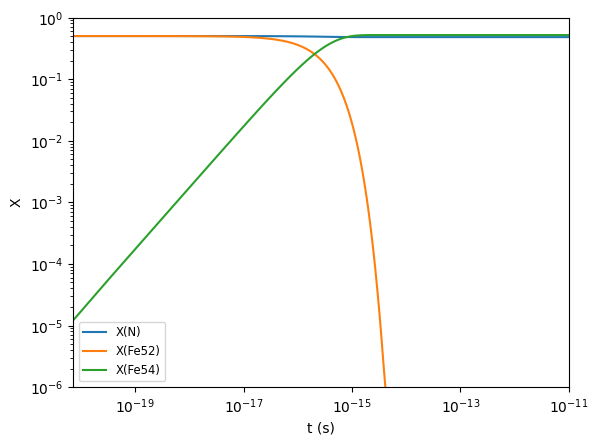

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(ncapture_approx.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * ncapture_approx.A[i],
              label=f"X({ncapture_approx.names[i].capitalize()})")

ax.set_xlim(right=1.e-11)
ax.set_ylim(1.e-6, 1)

ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

## Comparison

Finally, let's plot the nuclei in common from both nets together

(1e-06, 1)

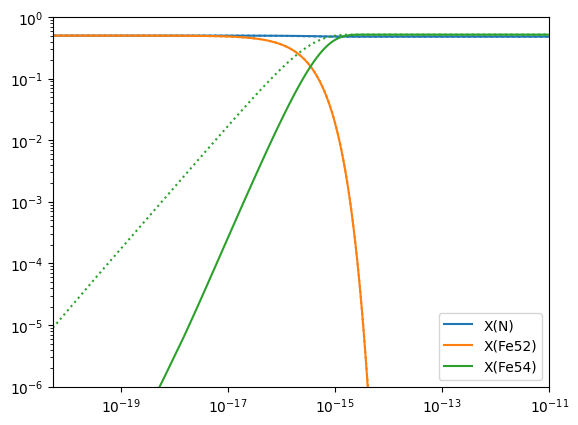

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(ncapture_approx.nnuc):
    ax.loglog(approx_sol.t, approx_sol.y[i,:] * ncapture_approx.A[i],
              linestyle=":", color=f"C{i}")

    idx = ncapture.names.index(ncapture_approx.names[i])
    ax.loglog(sol.t, sol.y[idx,:] * ncapture.A[idx],
              label=f"X({ncapture.names[idx].capitalize()})",
              linestyle="-", color=f"C{i}")

ax.legend()
ax.set_xlim(right=1.e-11)
ax.set_ylim(1.e-6, 1)

Here the dotted line is the approximate version.  We see that the ${}^{52}\mathrm{Fe}$ is consumed at the same rate.  The approximate net produces ${}^{54}\mathrm{Fe}$ faster simply because there is no intermediate ${}^{53}\mathrm{Fe}$ in the network.